In [1]:
cd '/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks/'

/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks


In [2]:
import pickle

import numpy as np
import pandas as pd 

from importlib import reload

import helper_funcs;reload(helper_funcs);from helper_funcs import *
import make_models;reload(make_models);from make_models import *

from functools import partial
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

from datetime import datetime

In [3]:
import shutil
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

### LOAD DATA

In [4]:
def norm_array(mat):
    mat[mat<0] = 0
    return (mat-mat.flatten().min()) / (mat.flatten().max()-mat.flatten().min())

In [5]:
ABIDE_data = np.load('/mmfs1/data/aglinska/ABIDE_data_rb.npz')['data']#.astype(np.float32)
print(ABIDE_data.shape)
ABIDE_data = np.array([norm_array(ABIDE_data[s,:,:,:]) for s in tqdm(range(ABIDE_data.shape[0]))])

cc = np.corrcoef(ABIDE_data.reshape(ABIDE_data.shape[0],-1)).mean(axis=0)
bad_idx = cc<.8

df = pd.read_csv('/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE_legend_S982.csv',header=0)
df.reset_index(inplace=True)
df = df.drop(df[bad_idx].index)

ABIDE_data = ABIDE_data[~bad_idx,:,:,:]
ABIDE_subs = df['BIDS_ID'].values

df.head(5)
print(ABIDE_data.shape)
print(df.shape)

  5%|▌         | 50/982 [00:00<00:01, 497.80it/s]

(982, 64, 64, 64)


100%|██████████| 982/982 [00:01<00:00, 500.69it/s]


(943, 64, 64, 64)
(943, 85)


In [6]:
# dataFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE-Anat-64iso-S982.npz'
# dfFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE_legend_S982.csv'


# ABIDE_data = np.load(dataFnOut)['data']
# ABIDE_data = np.load('/mmfs1/data/aglinska/ABIDErData.npy')
# df = pd.read_csv(dfFnOut)

In [7]:
patients = df['DxGroup'].values==1
controls = df['DxGroup'].values==2

In [8]:
arr = np.load('../Data/SFARI-Anat-64iso-S121.npz')
dfs = pd.read_csv('../Data/sfari_legend_S121.csv')

SFARI_data = arr['data']
SFARI_data = np.load('../Data/SFARIDatar.npz')['data']
SFARI_subs = arr['subs']

sfari_subs_td = dfs['family_type'].values=='non-familial-control'
sfari_subs_dupl = dfs['family_type'].values=='16p-duplication'
sfari_subs_del = dfs['family_type'].values=='16p-deletion'

### LOAD NETWORK WEIGHTS

In [9]:
# LOAD VAE
latent_dim=32;batch_size=64;disentangle=False;gamma=1
encoder, decoder, vae = get_MRI_VAE_3D(input_shape=(64, 64, 64, 1), latent_dim=latent_dim, batch_size=batch_size, disentangle=disentangle, gamma=gamma)
#fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Jan12th_16d'
#fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Feb_26_32DB64G1'
fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Feb_26_32DB64G100_DisTrue'


loss = list()
print('ready')
if os.path.exists(fn+'_loss.pickle'):
    print('loading')
    vae.load_weights(fn)
    loss = pickle.load(open(fn+'_loss.pickle','rb'))

ready
loading

Two checkpoint references resolved to different objects (<tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x1554400df670> and <tensorflow.python.keras.layers.core.Lambda object at 0x15545c04f6a0>).


In [10]:
items = get_weights(fdir=None)

00 | 16dim_noDis_evBatch
01 | Feb03_1459_D16B1G100_DTrue
02 | Feb04_0524_D16B1G100_DTrue
03 | Feb04_0524_D16B1G100_DTrue_continued
04 | Feb05_0908_D16B1G100_DTrue
05 | Feb23_1049_D16B1G1_DTrue
06 | Feb23_1400_D2B1G100_DTrue
07 | Feb23_1551_D16B1G100_DTrue
08 | Feb26_1330_CVAE_D16B1G1_adam
09 | Feb26_1330_forPaperFakeAbide
10 | Feb26_1330_playforClustering
11 | Feb_3d_16D_Dis_fixed
12 | Jan12_disentagled_l16
13 | Jan24_d16_dis_flipped_b5g20
14 | Jan24_d16_dis_flipped_b5g20_earlyStop
15 | Jan4th
16 | Mar18_1312_CVAE_D16B1G1_adam_rData
17 | Mar18_1312_CVAE_D16B1G1_adam_rData2
18 | Mar18_2009_CVAE_D16B1G100_adam4real_rData
19 | Mar18_2009_CVAE_D16B1G100_adam4real_rData2
20 | Mar18_2009_CVAE_D16B1G100_adam_rData2
21 | Mar18_2009_CVAE_D16B1G100_adam_rData3
22 | Mar18_2009_CVAE_D2B1G1_rmsprop
23 | Mar20_2125_CVAE_D16B1G100_adamBspline_r
24 | Mar20_2125_CVAE_D16B1G100_adamBspline_r2
25 | Mar20_2125_CVAE_D16B1G1_ADAM_Bspline_r2_new
26 | Mar20_2125_CVAE_D16B1G1_RMS_Bspline_r2
27 | checkpoint
28 

In [11]:
# LOAD CVAE
latent_dim = 16;batch_size = 32;beta = 1;gamma = 100;disentangle = True
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)
loss = list()    

fdir = '/mmfs1/data/aglinska/tf_outputs/CVAE/'

#fn = f'{now().strftime("%b%d_%H%M")}_D{latent_dim}B{beta}G{gamma}_D{disentangle}'
#fn = 'Feb04_0524_D16B1G100_DTrue'
#fn = os.path.join(fdir,'Mar18_1312_CVAE_D16B1G1_adam_rData2')
fn = os.path.join(fdir,'Mar20_2125_CVAE_D16B1G1_ADAM_Bspline_r2_new')

#fn = os.path.join(fdir,fn)
#fn = '/mmfs1/data/aglinska/tf_outputs/CVAE/Feb23_1551_D16B1G100_DTrue'

loss = pickle.load(open(fn+'_loss.pickle','rb'))
cvae.load_weights(fn)

### CHECK NETWORKS

In [12]:
sfari_td_batch = SFARI_data[sfari_subs_td,:,:,:][0:15,:,:,:]
sfari_dupl_batch = SFARI_data[sfari_subs_dupl,:,:,:][0:15,:,:,:]
sfari_del_batch = SFARI_data[sfari_subs_del,:,:,:][0:15,:,:,:]

asd_idx,td_idx = get_batch_idx(df,batch_size = batch_size)
DX_batch = np.take(ABIDE_data, indices=asd_idx, axis=0)
TD_batch = np.take(ABIDE_data, indices=td_idx, axis=0)

In [13]:
def cvae_predict(im_in,idx=1):
    # 0 for ASD, 1 for TD
    #im_in = [DX_batch,TD_batch][idx]
    _zeros = np.zeros(s_encoder(im_in)[2].shape)

    v = 2
    cvae_sal_vec = np.hstack((_zeros,s_encoder(im_in)[v]))
    cvae_bg_vec = np.hstack((z_encoder(im_in)[v],_zeros))

    if idx==1:
        cvae_full_vec = np.hstack((z_encoder(im_in)[v],s_encoder(im_in)[v]))
    elif idx==0:
        cvae_full_vec = cvae_bg_vec
        
    out = cvae_decoder.predict(cvae_full_vec)
    
    return out[:,:,:,:,0]

Text(0, 0.5, 'MSE')

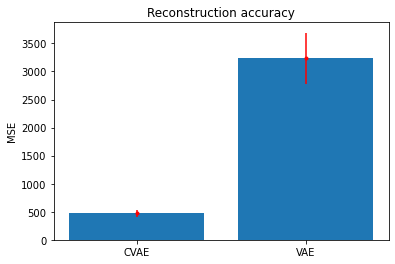

In [14]:
asd_idx,td_idx = get_batch_idx(df,batch_size = batch_size)
DX_batch = np.take(ABIDE_data, indices=asd_idx, axis=0)

matIn = DX_batch
n = matIn.shape[0]

vae_out = decoder.predict(encoder.predict(matIn)[2])[:,:,:,:,0]
cvae_out = cvae_predict(matIn,idx=1)

vae_resid = (matIn-vae_out)**2
cvae_resid = (matIn-cvae_out)**2

vae_acc = np.array([vae_resid[i,:,:,:].sum() for i in range(n)])
cvae_acc = np.array([cvae_resid[i,:,:,:].sum() for i in range(n)])

xs = [0,1];
m = [cvae_acc.mean(),vae_acc.mean()];
se = [cvae_acc.std(),vae_acc.std()];
plt.bar(xs,m);
plt.errorbar(xs,m,se,fmt='r.');
plt.xticks(xs,labels=['CVAE','VAE']);
plt.title('Reconstruction accuracy')
plt.ylabel('MSE')

### ^VAE is a bit worse at reconstruction overall. This needs to be fixed. For these analyses here it doesnt matter much because the reconstructions are still fairly ok. And also - we're mostly interested in the difference between BG and SL space

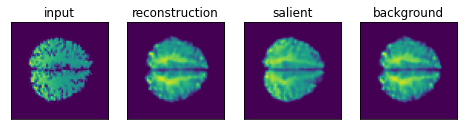

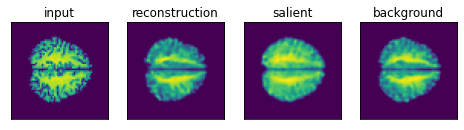

In [15]:
plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=0) # PLOT ASD SUBJECT
plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=1) # PLOT TD SUBJECT

### CVAE Reconstructions look good

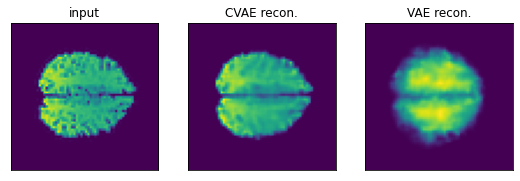

In [16]:
s = 1
plt.figure(figsize=(9,3))
plt.subplot(1,3,1);plt.imshow(matIn[s,:,:,40]);plt.title('input');plt.xticks([]);plt.yticks([]);
plt.subplot(1,3,2);plt.imshow(cvae_out[s,:,:,40]);plt.title('CVAE recon.');plt.xticks([]);plt.yticks([]);
plt.subplot(1,3,3);plt.imshow(vae_out[s,:,:,40]);plt.title('VAE recon.');plt.xticks([]);plt.yticks([]);

### For CVAE and VAE reconstruct the brain images well

In [17]:
w = 0
vae_space = dim_reduce(encoder.predict(ABIDE_data)[w])
bg_space,sl_space = get_spaces(ABIDE_data, z_encoder, s_encoder, w=w, method='UMAP')

### Distributions of ASD subjects in the three spaces. Evidence of clustering in BG, SL and VAE seem random (RSA results will show how they are organized)

449


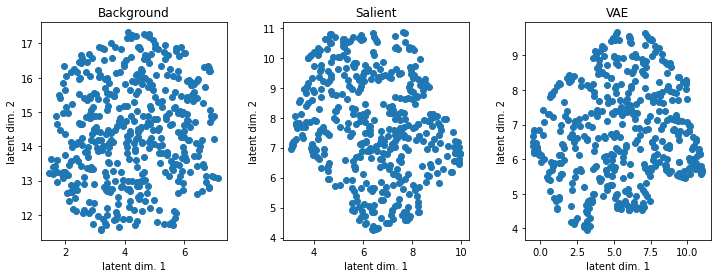

In [18]:
vae_space = dim_reduce(encoder.predict(ABIDE_data)[0])
bg_space,sl_space = get_spaces(ABIDE_data, z_encoder, s_encoder, w=0, method='UMAP')

fig = cscatter([bg_space,sl_space,vae_space],v=patients,return_axes=True)
#fig.savefig('/mmfs1/data/aglinska/figures/CVAE_clusters_nocolour.png')

51


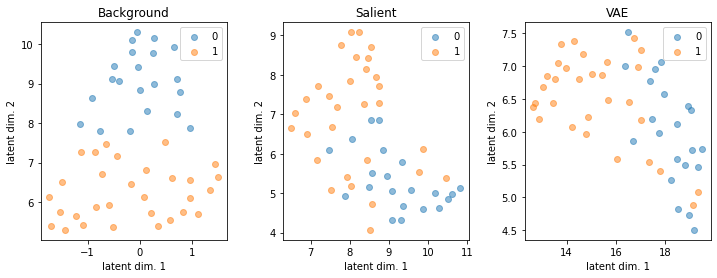

In [19]:
v = (sfari_subs_del+sfari_subs_dupl)
sfari_vae_space = dim_reduce(encoder.predict(SFARI_data[v,:,:,:])[0])
sfari_bg_space,sfari_sl_space = get_spaces(SFARI_data[v,:,:,:], z_encoder, s_encoder, w=0, method='UMAP')

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
KM = KMeans(n_clusters=2)
cid = KM.fit_predict(sfari_bg_space)
fig = cscatter([sfari_bg_space,sfari_sl_space,sfari_vae_space],return_axes=True,c=cid)
#fig.savefig('/mmfs1/data/aglinska/figures/SFARI_16pDEL_+DUPL_scatter.png')

In [20]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_val_score
# from sklearn import svm

# m1 = np.array(pd.get_dummies(dfc['ord_scanner']))
# m2 = dfc['age_years'].values[:,np.newaxis]
# m3 = np.array(pd.get_dummies(dfc['ord_sex']))
# m4 = np.array(dfc['svip_neuro_exam.background.head_circum_z_score'].values[:,np.newaxis])
# m5 = np.array([(SFARI_data[i,:,:,:]>0).sum()/(64**3) for i in range(SFARI_data.shape[0])])[v][:,np.newaxis]

# x = sfari_bg_space
# y = m1
# clf = LogisticRegression(penalty='l2',dual=False,tol=0.0001,C=1.0,fit_intercept=True,intercept_scaling=1,class_weight='balanced',random_state=None,solver='lbfgs',max_iter=100,multi_class='auto',verbose=0,warm_start=False,n_jobs=None,l1_ratio=None)
# scores = cross_val_score(clf, y, x_cid, cv=5)
# scores.mean()

# #fig = cscatter([sfari_bg_space,sfari_sl_space,sfari_vae_space],return_axes=True,c=dfc['ord_scanner'])

In [21]:
%%time
v = patients
rdm_bg = 1-make_RDM(bg_space[v,:],data_scale='ratio')
rdm_sl = 1-make_RDM(sl_space[v,:],data_scale='ratio')
rdm_vae = 1-make_RDM(encoder.predict(ABIDE_data)[2][v,:],data_scale='ratio')

CPU times: user 1.03 s, sys: 587 ms, total: 1.62 s
Wall time: 681 ms


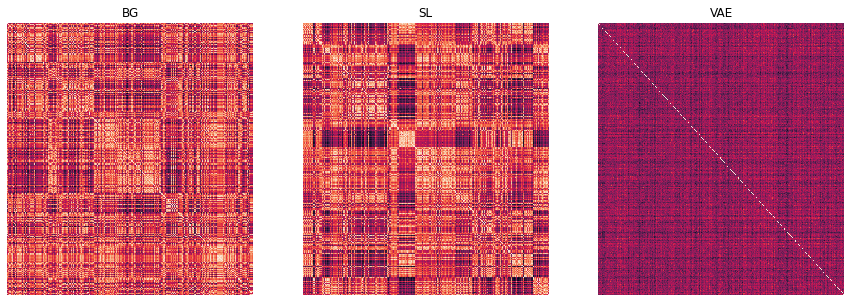

In [22]:
f, ax = plt.subplots(1,3,figsize=(15,5))
sns.heatmap(rdm_bg,cbar=[],ax=ax[0],xticklabels=[],yticklabels=[]);
sns.heatmap(rdm_sl,cbar=[],ax=ax[1],xticklabels=[],yticklabels=[]);
sns.heatmap(rdm_vae,cbar=[],ax=ax[2],xticklabels=[],yticklabels=[]);

[ax[i].set_title(['BG','SL','VAE'][i]) for i in range(3)];

plt.savefig('/mmfs1/data/aglinska/figures/' + 'RSASpaces' + '.png',dpi=300)

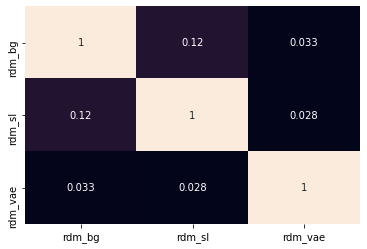

In [23]:
space_cmat = np.corrcoef(np.array([get_triu(x) for x in [rdm_bg,rdm_sl,rdm_vae]]));
lbls= ['rdm_bg','rdm_sl','rdm_vae'];
sns.heatmap(space_cmat,annot=True,cbar=[],xticklabels=lbls,yticklabels=lbls);

### RSA spaces for BG, SL and VAE look ok -  and they are not correlated

# RSA Analyses

RSA analyses of common variables in ASD subjects. 


ADOS, diagnosis (autism, aspergers, PDD-NOS) and FIQ are explained by salient space


Gender, scanner, scansite & age are pulled into background space

nice!

CPU times: user 29 µs, sys: 1e+03 ns, total: 30 µs
Wall time: 60.6 µs


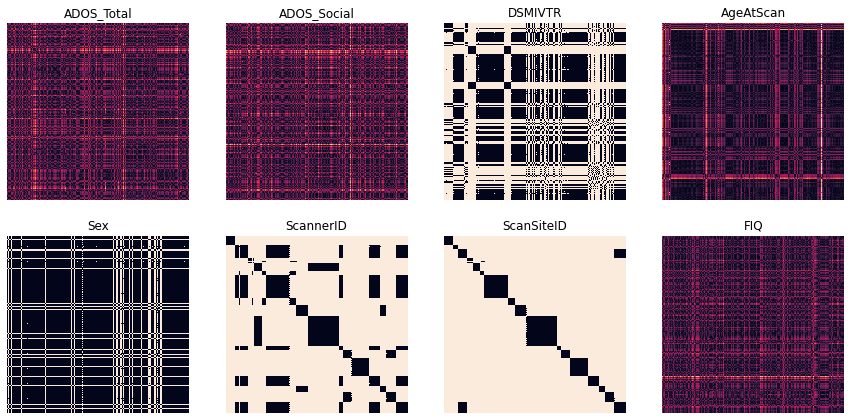

In [24]:
%time
plt.figure(figsize=(15,15))
default_keys = ['ADOS_Total','ADOS_Social','DSMIVTR','AgeAtScan','Sex','ScannerID','ScanSiteID','FIQ']
scales_ = ['ratio','ratio','ordinal','ratio','ordinal','ordinal','ordinal','ratio','ratio','ratio']

for i in range(8):
    plt.subplot(4,4,i+1);
    inVec = df[default_keys[i]].values[patients];
    inVec = inVec[~np.isnan(inVec)];
    this_rdm = make_RDM(inVec,data_scale=scales_[i])
    sns.heatmap(this_rdm,cbar=[],xticklabels=[],yticklabels=[]);
    plt.title(default_keys[i]);
    
#plt.savefig('/mmfs1/data/aglinska/figures/' + 'AbideModels' + '.png',dpi=300)

In [25]:
all_rsa_rsa_results = dict()

In [26]:
default_keys = ['ADOS_Total','ADOS_Social','DSMIVTR','AgeAtScan','Sex','ScannerID','ScanSiteID','FIQ']
scales_ = ['ratio','ratio','ordinal','ratio','ordinal','ordinal','ordinal','ratio','ratio','ratio']
for i in tqdm(range(len(default_keys))):
    #ax = plt.subplot(4,4,i+1)
    rsa_results = [fit_rsa(df[default_keys[i]].values,ABIDE_data,patients,[encoder,z_encoder,s_encoder],data_scale=scales_[i]) for _ in range(10)]
    all_rsa_rsa_results[default_keys[i]] = rsa_results = np.array(rsa_results)

100%|██████████| 8/8 [02:04<00:00, 15.50s/it]


Sanity check: common variables for TD subjects. Mostly represented in the background space.

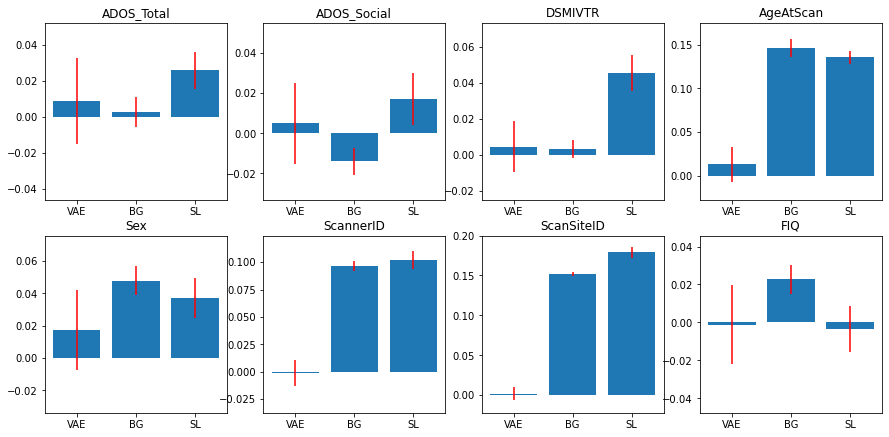

In [27]:
import helper_funcs;reload(helper_funcs);from helper_funcs import *
default_keys = ['ADOS_Total','ADOS_Social','DSMIVTR','AgeAtScan','Sex','ScannerID','ScanSiteID','FIQ']
plt.figure(figsize=(15,15))
for i in range(len(default_keys)):
    ax = plt.subplot(4,4,i+1)
    rsa_results = all_rsa_rsa_results[default_keys[i]].copy()
    range_ = (all_rsa_rsa_results[default_keys[i]].min(),all_rsa_rsa_results[default_keys[i]].max())
    #rsa_results[:,2] = 0;rsa_results[:,1] = 0
    plot_rsa_results(rsa_results,ax=ax,title=default_keys[i],xlbls=['VAE','BG','SL'])
    plt.ylim(range_[0]-.01,range_[1]+.01)
    
plt.savefig('/mmfs1/data/aglinska/figures/' + 'abidebarplots_asd' + '.png',dpi=300)

CPU times: user 1min 53s, sys: 58.4 s, total: 2min 52s
Wall time: 1min 29s


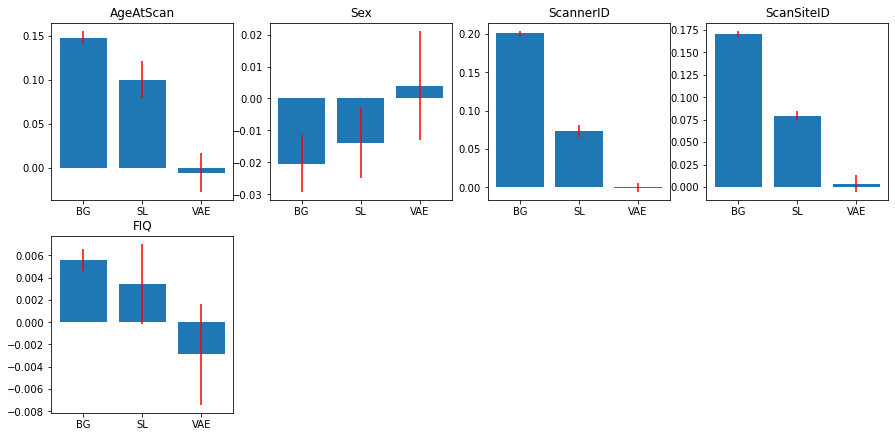

In [60]:
%%time
default_keys = ['AgeAtScan','Sex','ScannerID','ScanSiteID','FIQ']
scales_ = ['ratio','ratio','ordinal','ratio','ordinal','ordinal','ordinal','ratio','ratio','ratio']
plt.figure(figsize=(15,15))

for i in range(len(default_keys)):
    ax = plt.subplot(4,4,i+1)
    rsa_results = [fit_rsa(df[default_keys[i]].values,ABIDE_data,controls,[z_encoder,s_encoder,encoder],data_scale=scales_[i]) for _ in range(10)]
    rsa_results = np.array(rsa_results)
    plot_rsa_results(rsa_results,ax=ax,title=default_keys[i])
    
#plt.savefig('/mmfs1/data/aglinska/figures/' + 'abidebarplots_td' + '.png',dpi=300)

There are different ADOS and ADI measurements (see keys below). They index social impairements, communication aspects etc.

ADOS is a questionaire administer to the child and indexes current behaviors. 

ADI is a questionaire (interview) administered to the parents and indexes both current and longer scale patterns of behavior. 

First - let's take the PCA of the ADOS and ADI scores and compute RDM based on PCs (similarity in component loading) and compare that RSA to background, salient and VAE spaces.

I compute three PCs and plot one the ones that explain 25% or more variance. In the scores below, first PC explains 48% of variance, 2nd explains 32% and 3rd explains 7% so only the first two PCs are anlyzed. 

In [29]:
#all_rsa_rsa_results

In [30]:
# %%time
# default_keys = ['SRS_awareness', 'SRS_cognition', 'SRS_communication',
#        'SRS_motivation', 'SRS_manierisms']

# scales_ = ['ratio','ratio','ratio','ratio','ratio','ratio','ratio','ratio',None,None,None,None,None,None,None,None,None,None,None,None,None,None]
# plt.figure(figsize=(15,15))
# for i in range(len(default_keys)):
#     ax = plt.subplot(4,4,i+1)
#     rsa_results = [fit_rsa(df[default_keys[i]].values,ABIDE_data,patients,[z_encoder,s_encoder,encoder],data_scale=scales_[i]) for _ in range(10)]
#     rsa_results = np.array(rsa_results)
#     plot_rsa_results(rsa_results,ax=ax,title=default_keys[i])
# #plt.savefig('/mmfs1/data/aglinska/figures/' + 'abide_asd_barplots_other' + '.png',dpi=300)

269 subjects
[0.91353629 0.04877018 0.03361605]
CPU times: user 18.1 s, sys: 9.78 s, total: 27.9 s
Wall time: 11.7 s


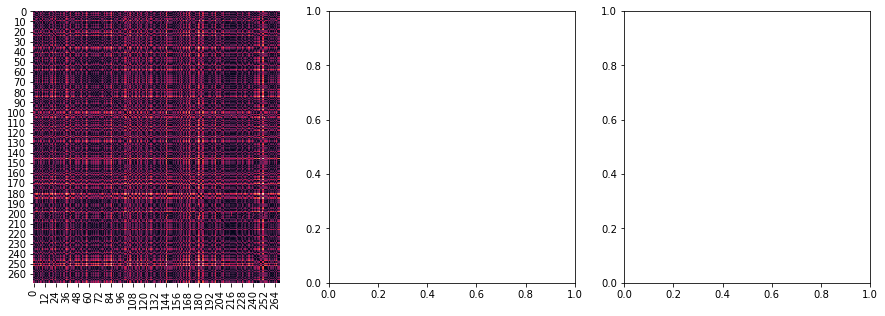

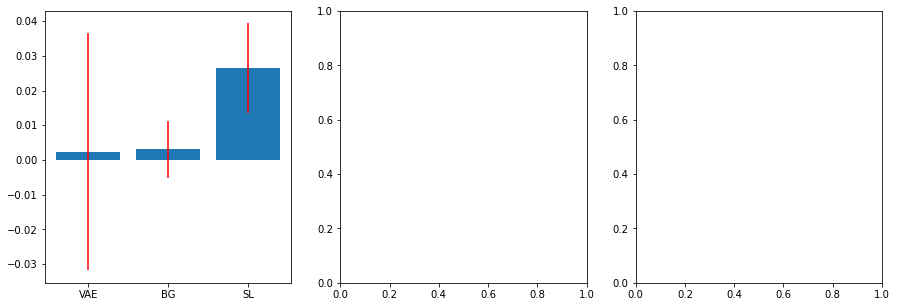

In [31]:
%%time
keys = ['ADOS_Total','ADOS_Comm', 'ADOS_Social', 'ADOS_StBeh']
pca_res = plot_pca_rsa(keys,df,ABIDE_data,patients,[encoder,z_encoder,s_encoder],xlbls=['VAE','BG','SL'],thresh=.1)
all_rsa_rsa_results['ADOS_PC1'] = pca_res[0]
# all_rsa_rsa_results['ADI_PC2'] = pca_srs[1]

268 subjects
[0.76733279 0.12334516 0.08913942]
CPU times: user 18.3 s, sys: 8.17 s, total: 26.5 s
Wall time: 11.6 s


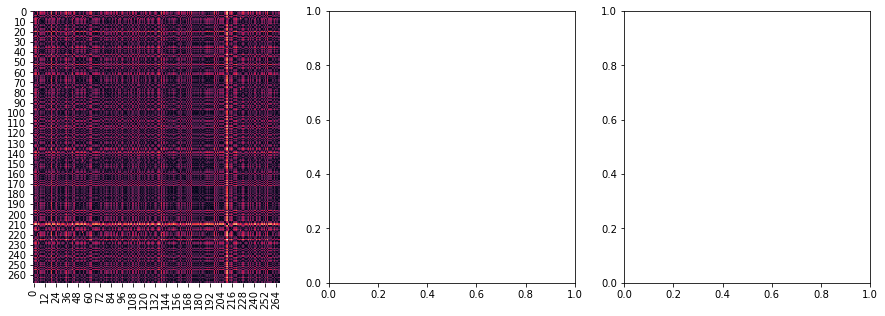

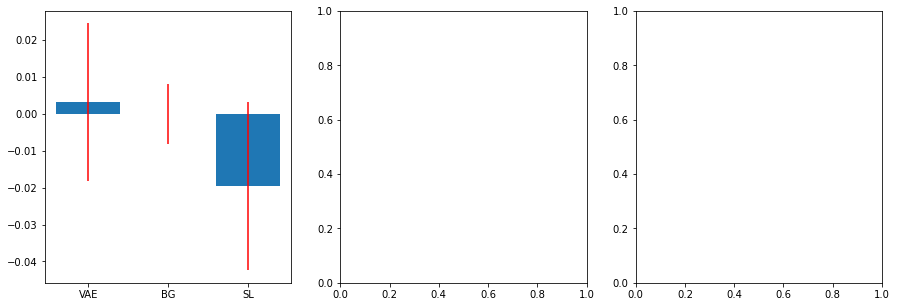

In [32]:
%%time
keys = ['ADI_R_SocialTotal', 'ADI_R_VerbalTotal', 'ADI_R_RRB','ADI_R_Onset Total']
pca_srs = plot_pca_rsa(keys,df,ABIDE_data,patients,[encoder,z_encoder,s_encoder],xlbls=['VAE','BG','SL'],thresh=.25)
all_rsa_rsa_results['ADI_PC1'] = pca_srs[0]
#all_rsa_rsa_results['ADI_PC2'] = pca_srs[1]

In [33]:
# %%time
# keys = ['SRS_awareness', 'SRS_cognition', 'SRS_communication','SRS_motivation', 'SRS_manierisms']
# pca_result = plot_pca_rsa(keys,df,ABIDE_data,patients,[encoder,z_encoder,s_encoder],xlbls=['VAE','BG','SL'],thresh=.25)
# all_rsa_rsa_results['SRS_PCA'] = pca_result[0]

In [34]:
# %%time
# keys =['FIQ', 'VIQ', 'PIQ']
# pca_result = plot_pca_rsa(keys,df,ABIDE_data,patients,[encoder,z_encoder,s_encoder],xlbls=['VAE','BG','SL'],thresh=.25)
# all_rsa_rsa_results['IQ_PCA'] = pca_result

189 subjects
[0.93022121 0.05991317 0.00973226]
CPU times: user 9.23 s, sys: 5.69 s, total: 14.9 s
Wall time: 8.36 s


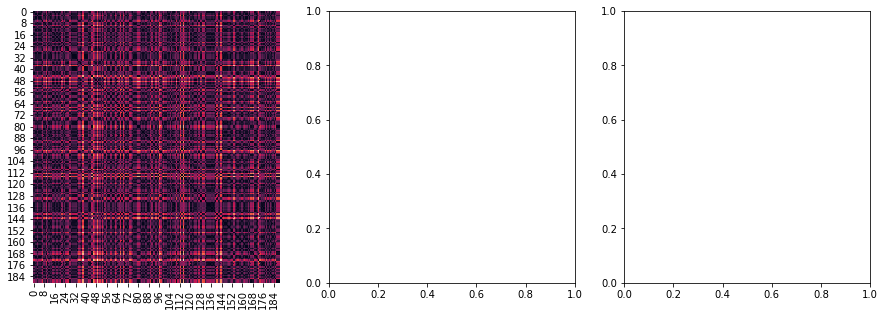

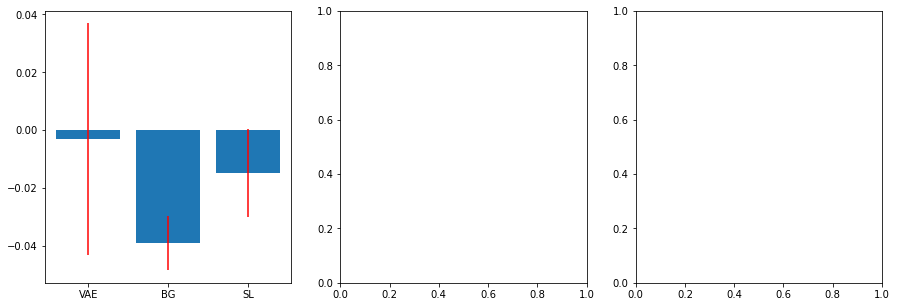

In [35]:
%%time
keys = ['ADOSGotham_SocAffect', 'ADOSGotham_Rest-RepBeh','ADOSGotham_Total', 'ADOSGotham_Severity']
pca_result = plot_pca_rsa(keys,df,ABIDE_data,patients,[encoder,z_encoder,s_encoder],xlbls=['VAE','BG','SL'])
all_rsa_rsa_results['ADOS_gotham_PC1'] = pca_result[0]

### Seems like the salient space is sensitive to differences in ADOS scores (across both PCs). The negative values for BG in 1st PC analyses are hard to interpret (ASD subjects that are different in ADOS RDM are similar in BG rdm)

And here are the model fits for individual ADOS and ADI measurements. These would probably go in the appendix

CPU times: user 3min, sys: 1min 44s, total: 4min 45s
Wall time: 2min 33s


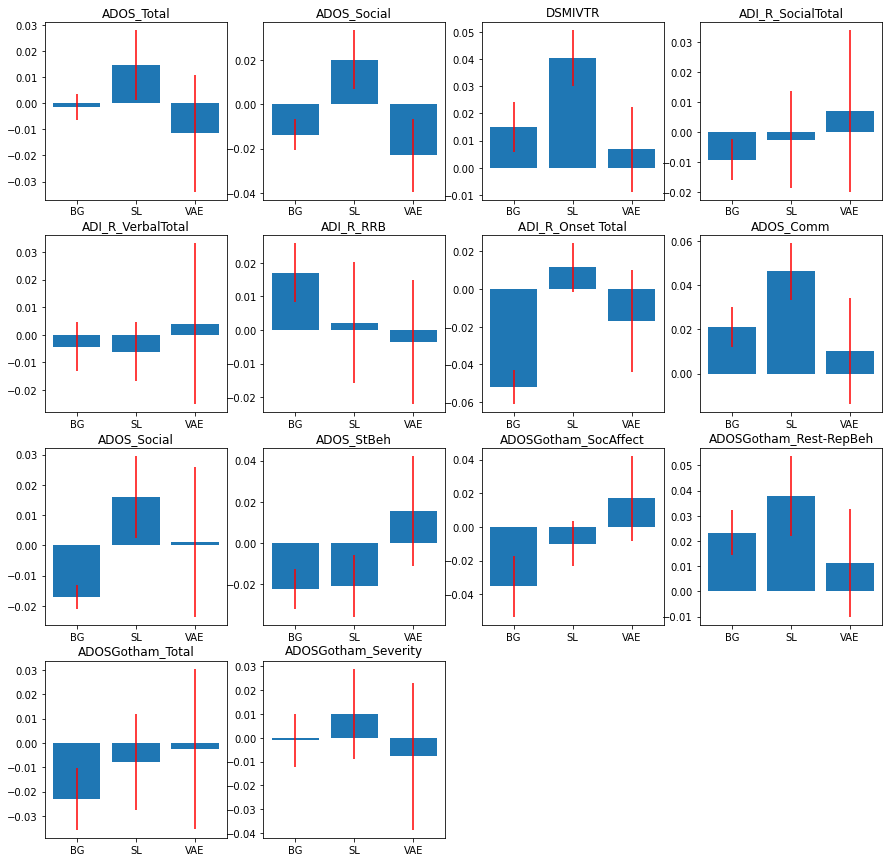

In [36]:
%%time
default_keys = ['ADOS_Total','ADOS_Social','DSMIVTR','ADI_R_SocialTotal','ADI_R_VerbalTotal','ADI_R_RRB','ADI_R_Onset Total','ADOS_Comm','ADOS_Social','ADOS_StBeh','ADOSGotham_SocAffect', 'ADOSGotham_Rest-RepBeh',
       'ADOSGotham_Total', 'ADOSGotham_Severity']

scales_ = ['ratio','ratio','ordinal','ratio','ratio','ratio','ratio','ratio',None,None,None,None,None,None,None,None,None,None,None,None,None,None]
plt.figure(figsize=(15,15))
for i in range(len(default_keys)):
    ax = plt.subplot(4,4,i+1)
    rsa_results = [fit_rsa(df[default_keys[i]].values,ABIDE_data,patients,[z_encoder,s_encoder,encoder],data_scale=scales_[i]) for _ in range(10)]
    rsa_results = np.array(rsa_results)
    plot_rsa_results(rsa_results,ax=ax,title=default_keys[i])
    
plt.savefig('/mmfs1/data/aglinska/figures/' + 'abide_asd_barplots_other' + '.png',dpi=300)

# VINELAND scores

"The Vineland Adaptive Behavior Scales (VABS) (Vineland-3) is a standardized assessment tool that utilizes semi-structured interview to measure adaptive behavior and support the diagnosis of intellectual and developmental disabilities, autism, and developmental delays. It may be used to determine eligibility or qualification for special services, plan rehabilitation or intervention programs, and track and report progress"


[link about Vineland](https://www.pearsonassessments.com/store/usassessments/en/Store/Professional-Assessments/Behavior/Adaptive/Vineland-Adaptive-Behavior-Scales-%7C-Third-Edition/p/100001622.html)

In [37]:
# There are multiple measures (aspects) of VINELAND scores (see keys below). 
keys = ['VINELAND_Receptive_Vscore',
 'VINELAND_Expressive_Vscore',
 'VINELAND_Written_Vscore',
 'VINELAND_CommunicationStandard',
 'VINELAND_Personal_Vscore',
 'VINELAND_Domestic_Vscore',
 'VINELAND_Community_Vscore',
 'VINELAND_DaylyLiving_Standard',
 'VINELAND_Interpersonal_Vscore',
 'VINELAND_Play_Vscore',
 'VINELAND_Coping_Vscore',
 'VINELAND_Socical_Standard',
 'VINELAND_Domestic_Standard',
 'VINELAND_ABC_Standard',
 'VINELAND_Informant']

First - let's take the PCA of the vineland scores and compute RDM (similarity in component loading) and compare that RSA to background, salient and VAE spaces.

I compute three PCs and plot one the ones that explain 25% or more variance. In the scores below, first PC explains 93% of variance, 2nd explains 2% and 3rd explains 1.7% so only the first PC is anlyzed. 

67 subjects
[0.93366284 0.02121328 0.01839099]


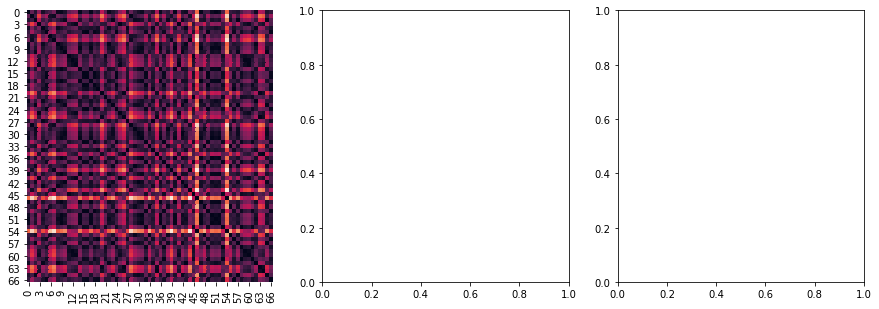

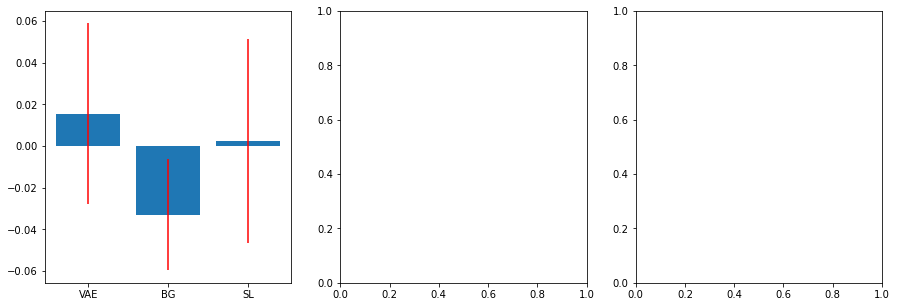

In [38]:
pca_vineland_asd = plot_pca_rsa(keys,df,ABIDE_data,patients,[encoder,z_encoder,s_encoder],xlbls=['VAE','BG','SL'])
all_rsa_rsa_results['Vineland_PC1'] = pca_result[0]
# ASD subjects
# Matrix shows similarity in Vineland scores between participants with ASD
# Bar graphs shows model fit to background, salient and VAE space RDMs
# ASD participants that differ in Vineland scores also differ in the salient space embedding

Vineland scores for TD subjects: no effect in salient space

43 subjects
[0.93366284 0.02121328 0.01839099]


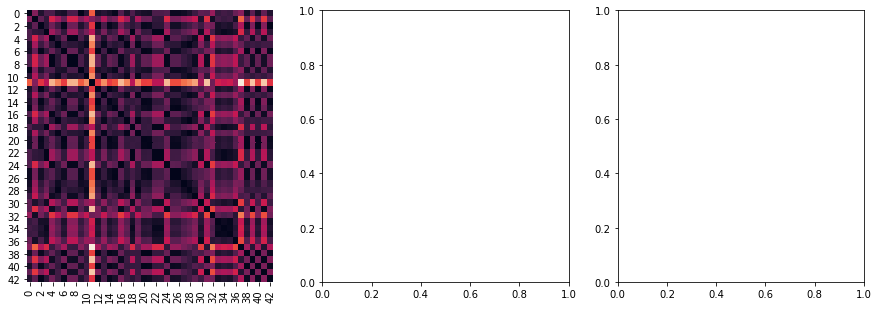

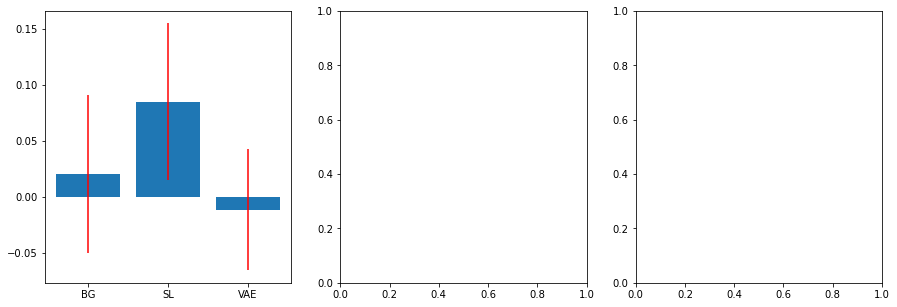

In [39]:
pca_vineland_td = plot_pca_rsa(keys,df,ABIDE_data,controls,[z_encoder,s_encoder,encoder])
# Vineland scores for controls. No effects

### Individual vineland measures fit to data

For visualization - instead of doing PCA let's run model fit for individual scores. This is something for the appendix

CPU times: user 56.3 s, sys: 28.9 s, total: 1min 25s
Wall time: 49.4 s


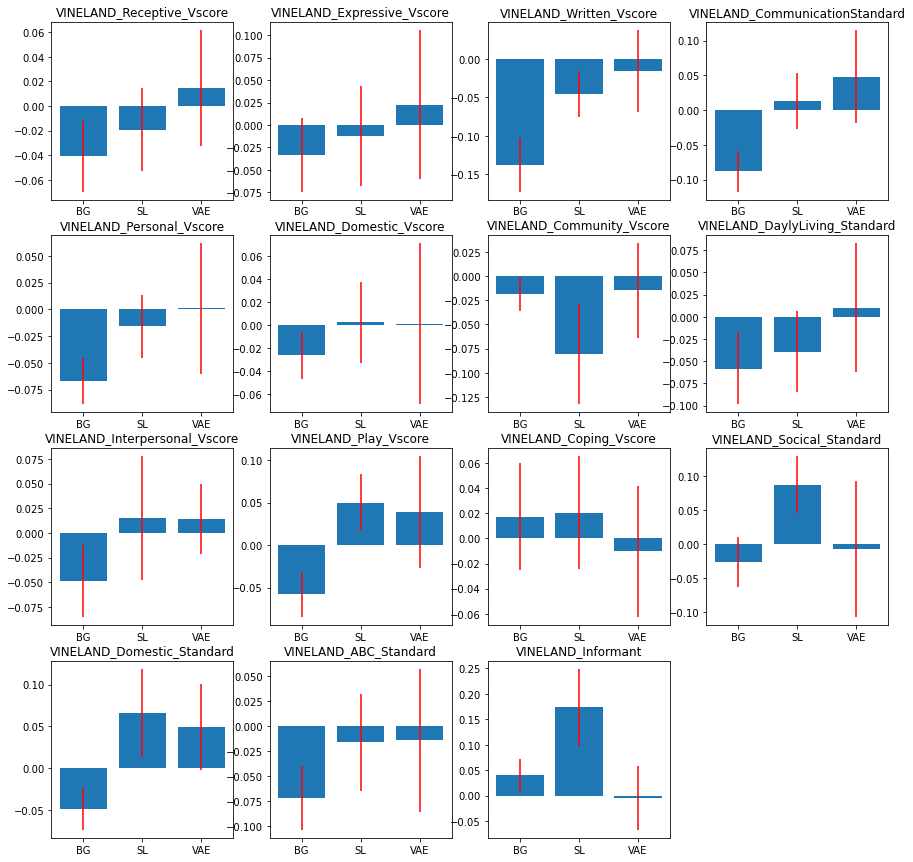

In [40]:
%%time
default_keys = ['VINELAND_Receptive_Vscore',
 'VINELAND_Expressive_Vscore',
 'VINELAND_Written_Vscore',
 'VINELAND_CommunicationStandard',
 'VINELAND_Personal_Vscore',
 'VINELAND_Domestic_Vscore',
 'VINELAND_Community_Vscore',
 'VINELAND_DaylyLiving_Standard',
 'VINELAND_Interpersonal_Vscore',
 'VINELAND_Play_Vscore',
 'VINELAND_Coping_Vscore',
 'VINELAND_Socical_Standard',
 'VINELAND_Domestic_Standard',
 'VINELAND_ABC_Standard',
 'VINELAND_Informant']

scales_ = [None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None]
plt.figure(figsize=(15,15))
#[plt.subplot(4,4,i+1) for i in range(8)];

for i in range(len(default_keys)):
    ax = plt.subplot(4,4,i+1)
    rsa_results = [fit_rsa(df[default_keys[i]].values,ABIDE_data,patients,[z_encoder,s_encoder,encoder],data_scale=scales_[i]) for _ in range(10)]
    rsa_results = np.array(rsa_results)
    all_rsa_rsa_results[default_keys[i]]=rsa_results
    plot_rsa_results(rsa_results,ax=ax,title=default_keys[i])

### WISC4 is the Wechsler Intelligence Scale for Children: only PCA results (for computational convenience)

21 subjects
[0.59007247 0.16274116 0.13768305]
CPU times: user 1.84 s, sys: 404 ms, total: 2.24 s
Wall time: 1.74 s


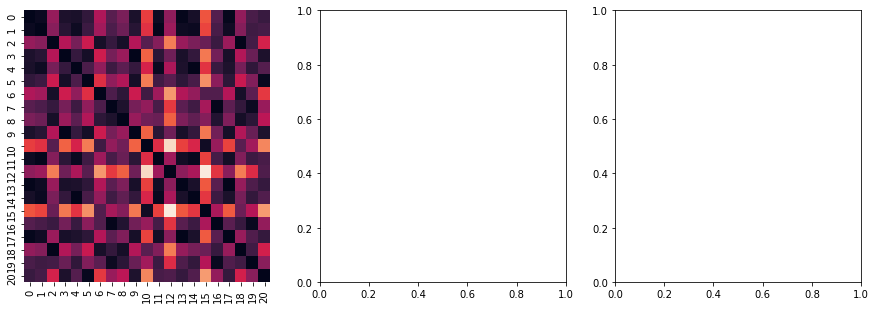

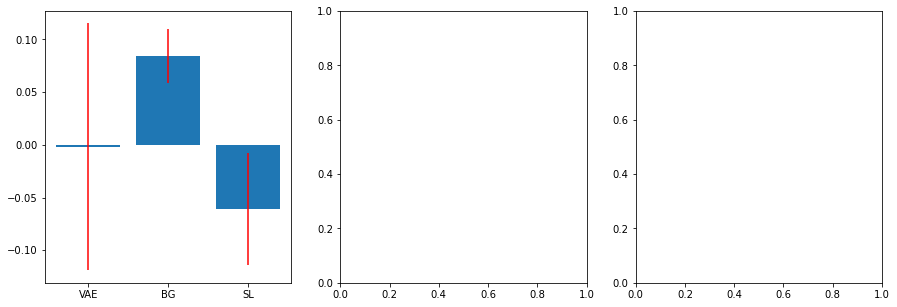

In [41]:
%%time
keys = ['WISC4 VCI Verbal Comprehension Index',
       'WISC4 PRI Perceptual Reasoning Index',
       'WISC4 WMI Working Memory Index', 'WISC4 PSI Processing Speed Index',
       'WISC4 Sim Scaled', 'WISC4 Vocab Scaled', 'WISC4 Info Scaled',
       'WISC4 Blk Dsn Scaled', 'WISC4 Pic Con Scaled', 'WISC4 Matrix Scaled',
       'WISC4 Dig Span Scaled', 'WISC4 Let Num Scaled', 'WISC4 Coding Scaled',
       'WISC4 Sym Scaled']

wisc_res_ASD = plot_pca_rsa(keys,df,ABIDE_data,patients,[encoder,z_encoder,s_encoder],xlbls=['VAE','BG','SL'])
all_rsa_rsa_results['WISC_PC1'] = wisc_res_ASD[0]

Overall - background space is sensitive to differences in common confounds and salient space is sensitive to ADOS and IQ scores of patients

In [42]:
# %%time 
# keys = ['WISC4 VCI Verbal Comprehension Index',
#        'WISC4 PRI Perceptual Reasoning Index',
#        'WISC4 WMI Working Memory Index', 'WISC4 PSI Processing Speed Index',
#        'WISC4 Sim Scaled', 'WISC4 Vocab Scaled', 'WISC4 Info Scaled',
#        'WISC4 Blk Dsn Scaled', 'WISC4 Pic Con Scaled', 'WISC4 Matrix Scaled',
#        'WISC4 Dig Span Scaled', 'WISC4 Let Num Scaled', 'WISC4 Coding Scaled',
#        'WISC4 Sym Scaled']

# wisc_res_TD = plot_pca_rsa(keys,df,ABIDE_data,controls,[z_encoder,s_encoder,encoder])

In [43]:
PCA(n_components=1).fit_transform

<bound method PCA.fit_transform of PCA(n_components=1)>

In [44]:
from plotnine import *
from plotnine import geoms

In [45]:
#mat = np.array([wisc_res_TD[0],wisc_res_ASD[0]])
mat = np.array([pca_vineland_td[0],pca_vineland_asd[0]])
mat = np.swapaxes(mat,0,1)
mat.shape

(10, 2, 3)

In [46]:
columns = ['fit','group','enc']
lbls = [['TD','ASD'],['vae','bg','sl']]

In [47]:
l = np.zeros(mat.shape)
l = np.array(l, dtype='object')
l[:,0,:] = 'TD'
l[:,1,:] = 'ASD'
g = l.flatten()

In [48]:
l = np.zeros(mat.shape)
l = np.array(l, dtype='object')
l[:,:,0] = 'VAE'
l[:,:,1] = 'BG'
l[:,:,2] = 'SL'
e = l.flatten()

In [49]:
myDF = pd.DataFrame(columns=columns)
myDF['fit'] = mat.flatten()
myDF['group'] = g.flatten()
myDF['enc'] = e.flatten()

Text(0.5, 1.0, 'VINELAND PCA')

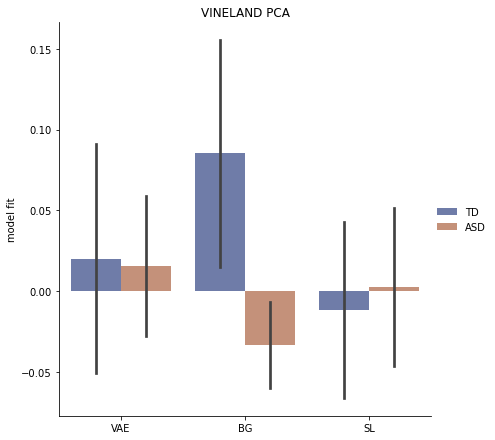

In [50]:
# Draw a nested barplot by species and sex
#plot_df = fit_df[fit_df["enc"].isin(['sl','bg'])]
plot_df = myDF

g = sns.catplot(
    data=plot_df, kind="bar",
    x="enc", y="fit", hue="group",
    ci="sd", palette="dark", alpha=.6, height=6
)

#g.despine(left=True)
g.set_axis_labels("", "model fit")
g.legend.set_title("")
plt.title('VINELAND PCA')

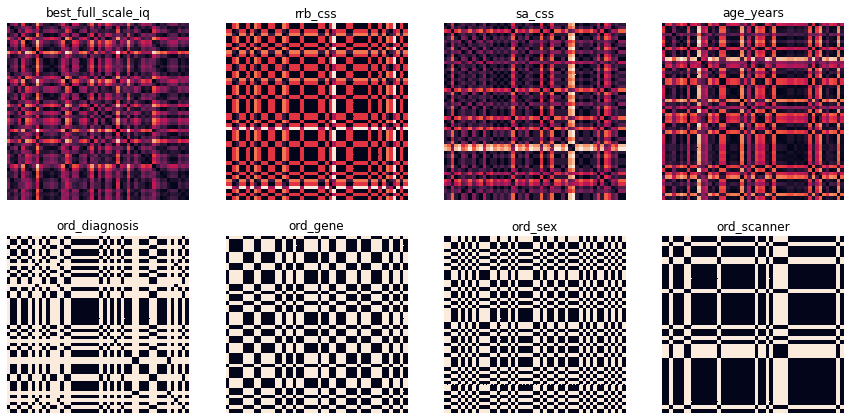

In [51]:
plt.figure(figsize=(15,15))

default_keys = ['best_full_scale_iq','rrb_css','sa_css','age_years', 'ord_diagnosis',
       'ord_gene', 'ord_sex','ord_scanner']
scales_ = [None,None,None,None,'ordinal','ordinal','ordinal','ordinal']

for i in range(8):
    plt.subplot(4,4,i+1);
    inVec = dfs[default_keys[i]].values[(sfari_subs_del+sfari_subs_dupl)];
    inVec = inVec[~np.isnan(inVec)];
    sns.heatmap(make_RDM(inVec,data_scale=scales_[i]),cbar=[],xticklabels=[],yticklabels=[]);
    plt.title(default_keys[i]);
    
plt.savefig('/mmfs1/data/aglinska/figures/' + 'sfari_models' + '.png',dpi=300)

In [52]:
default_keys = ['age_months','best_full_scale_iq','rrb_css','sa_css','age_years', 'ord_diagnosis',
       'ord_gene', 'ord_sex','ord_scanner']
scales_ = [None,None,None,None,None,'ordinal','ordinal','ordinal','ordinal']

for i in tqdm(range(len(default_keys))):
    rsa_results = [fit_rsa(dfs[default_keys[i]].values,SFARI_data,(sfari_subs_del+sfari_subs_dupl),[encoder,z_encoder,s_encoder],data_scale=scales_[i]) for _ in range(10)]
    rsa_results = np.array(rsa_results)
    all_rsa_rsa_results['sfari_' + default_keys[i]] = rsa_results

100%|██████████| 9/9 [00:31<00:00,  3.48s/it]


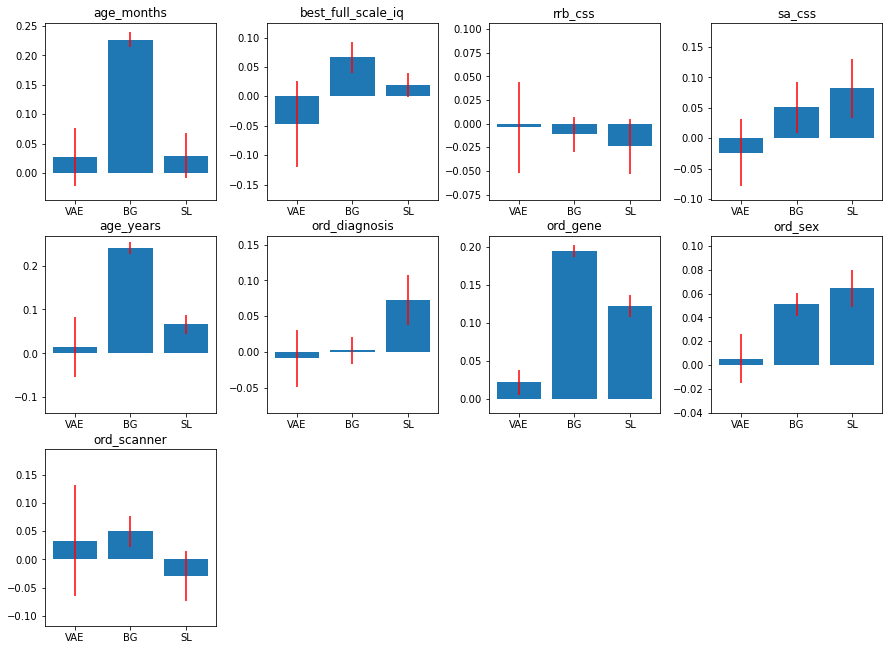

In [53]:

default_keys = ['age_months','best_full_scale_iq','rrb_css','sa_css','age_years', 'ord_diagnosis',
       'ord_gene', 'ord_sex','ord_scanner']

plt.figure(figsize=(15,15))
for i in range(len(default_keys)):
    ax = plt.subplot(4,4,i+1)
    rsa_results = all_rsa_rsa_results['sfari_' + default_keys[i]].copy();range_ = (rsa_results.min(),rsa_results.max())
    #rsa_results[:,1] = 0;rsa_results[:,2] = 0
    
    plot_rsa_results(rsa_results,ax=ax,title=default_keys[i],xlbls=['VAE','BG','SL'])   
    plt.ylim(range_[0]-.01,range_[1]+.01)
    plt.subplots_adjust(hspace=None,wspace=.3)
    
#plt.savefig('/mmfs1/data/aglinska/figures/' + 'sfari_barplots_vae' + '.png',dpi=300)

In [54]:
#all_rsa_rsa_results[keys[i]] = all_rsa_rsa_results[keys[i]][0]

In [55]:
keys = ['ADOS_Total',
 'ADOS_Social',
 'DSMIVTR',
 'AgeAtScan',
 'Sex',
 'ScannerID',
 'ScanSiteID',
 'FIQ',
 'WISC_PC1',
 'ADI_PC1',
 'ADOS_PC1',
 'Vineland_PC1',
'ADOS_gotham_PC1']

In [56]:
#keys = ['ADOS_Total', 'ADOS_Social', 'DSMIVTR', 'AgeAtScan', 'Sex', 'ScannerID', 'ScanSiteID', 'FIQ','WISC_PC1']
#keys = ['sfari_age_months', 'sfari_best_full_scale_iq', 'sfari_rrb_css', 'sfari_sa_css', 'sfari_age_years', 'sfari_ord_diagnosis', 'sfari_ord_gene', 'sfari_ord_sex', 'sfari_ord_scanner']
#keys = list(all_rsa_rsa_results.keys())

In [63]:
n = len(keys)
m = np.array([(all_rsa_rsa_results[keys[i]][:,2]-all_rsa_rsa_results[keys[i]][:,1]).mean() for i in range(n)])
se = np.array([(all_rsa_rsa_results[keys[i]][:,2]-all_rsa_rsa_results[keys[i]][:,1]).std() for i in range(n)])

In [64]:
# n = len(keys)
# m = np.array([(all_rsa_rsa_results[keys[i]][:,2]).mean() for i in range(n)])
# se = np.array([(all_rsa_rsa_results[keys[i]][:,2]).std() for i in range(n)])

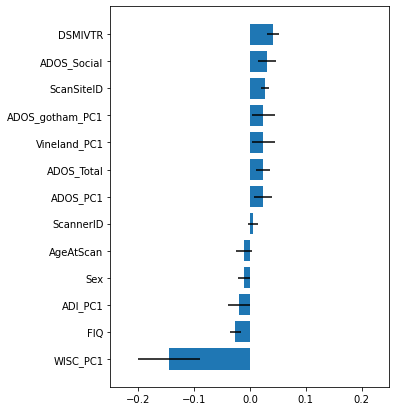

In [65]:
plt.figure(figsize=(5,7))
ys = np.arange(len(m));
width = np.array(m);
lbls = np.array(keys);
ord_ = np.argsort(m)

width = width[ord_]
lbls = lbls[ord_]
plt.barh(y=ys, width=width,xerr=se[ord_],height=0.8, left=None, align='center');
plt.xlim(-.25,.25);
plt.yticks(ys,labels=lbls);
zp = np.nonzero(width>0)[0][0]-.55
#plt.plot((-.5,.5),(zp,zp),'k.-',alpha=.5)

In [59]:
#cd '/mmfs1/data/aglinska/'